<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_StateSpace_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages( "KFAS" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’




目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は場合分けをせず、時系列分析します。

# 手順１　データの収集


*　[データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [2]:
# 該当リポジトリを変数に格納
repo = 
  c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" )

# 人口推計に使うデータの格納場所を変数に格納
popURL = 
  c( "main/data/population_jp_year.csv" )

# ライブラリの読み込み
library( readr )
library( dplyr )

repo |>
  paste0( popURL ) |>                     # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  select( Year, Total ) |>                # 総人口のみのデータにする
  mutate( Year = {
    paste0( Year, "-10-01" ) |>           # １０月１日現在の日付型にする
      as.Date()}
  ) ->
pop_df 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# 手順２　データの可視化

まず、データをプロットしてみます。

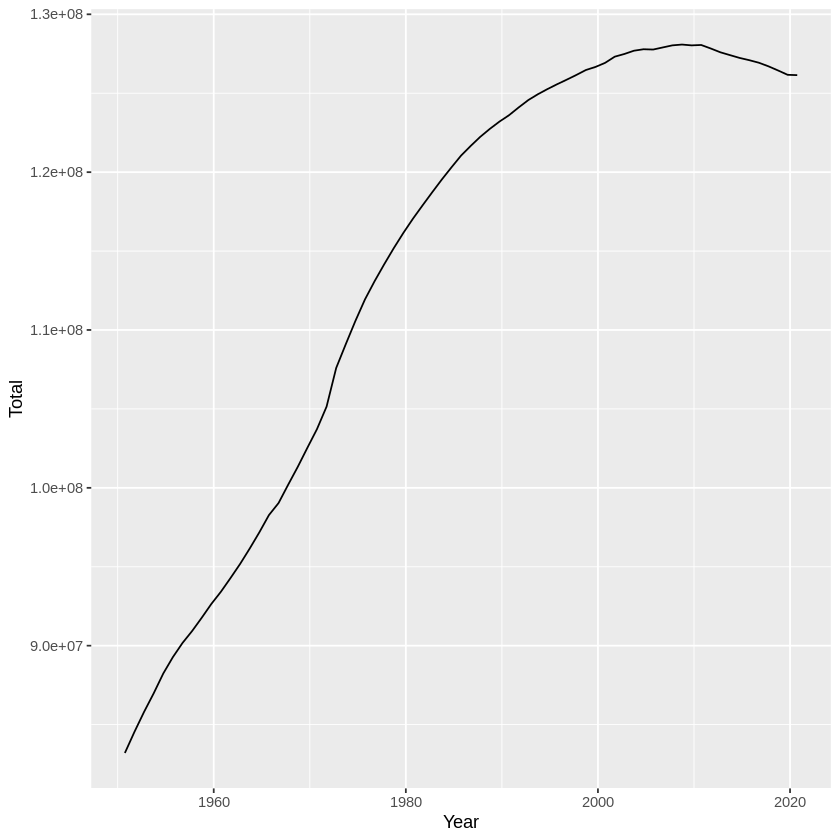

In [3]:
# ライブラリの読み込み
library( ggplot2 )

# 総人口のグラフ
pop_df |>
ggplot( aes( x = Year,
             y = Total)) +
  geom_line()

次に、自己相関を確認してみます。

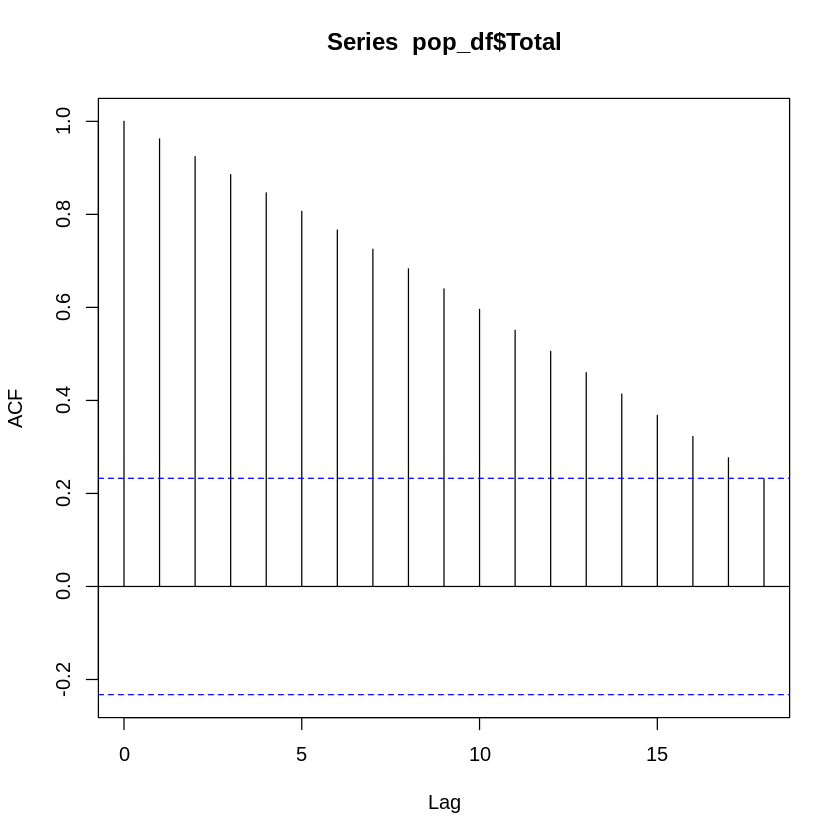

In [4]:
# 自己相関のグラフ
pop_df$Total |>
  acf() 

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

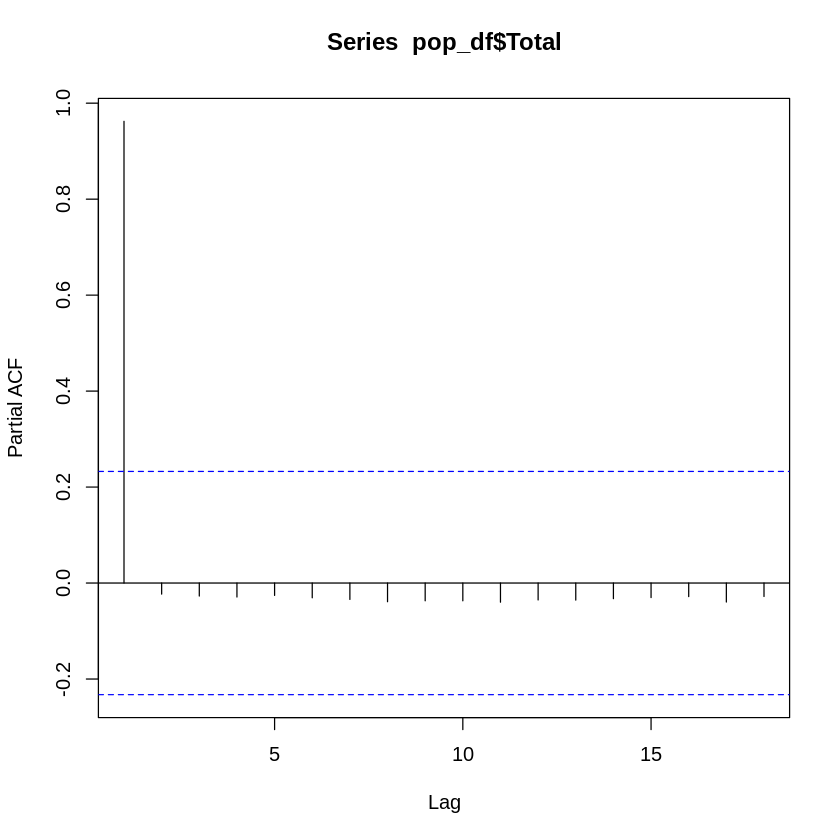

In [5]:
# 偏自己相関のグラフ
pop_df$Total |>
  pacf() 

# 手順３　学習データと予測データの分類

２０１５年までのデータを学習データとし、その後５年間のデータを予測データとします。

In [6]:
# 学習データと予測データ
prow_test = 5
prow_train = nrow( pop_df ) - prow_test

pop_df |>
  tail( n = prow_test ) ->
pop_test

pop_df |>
  head( n = prow_train ) ->
pop_train

# 手順４　状態空間モデルによる予測

ローカル線形トレンドモデルを使用して、予測をしてみます。

In [7]:
# ライブラリの読み込み
library( KFAS )

# モデル構造の決定
SSModel( H = NA,
         pop_train$Total ~ SSMtrend( degree = 2,
                                     Q = list( NA, NA ))) |>
  fitSSM( inits = c( 1, 1, 1 )) ->        # パラメタ推定
fit_trend

# 将来予測の結果と予測区間
fit_trend$model |>
  predict( interval = "prediction",
           n.ahead = 5 ) |>
  as.data.frame() ->
forecast_trend

Please cite KFAS in publications by using: 

  Jouni Helske (2017). KFAS: Exponential Family State Space Models in R. Journal of Statistical Software, 78(10), 1-39. doi:10.18637/jss.v078.i10.



# 手順５　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast,DMBM,DMBH,DLBM,DLBH
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-10-01,126933000,126952934,126838000,126864000,126912000,126938000
2017-10-01,126706000,126810884,126532000,126605000,126704000,126777000
2018-10-01,126443000,126668835,126177000,126315000,126441000,126580000
2019-10-01,126167000,126526785,125773000,125998000,126125000,126351000
2020-10-01,126146000,126384736,125325000,125658000,125761000,126094000


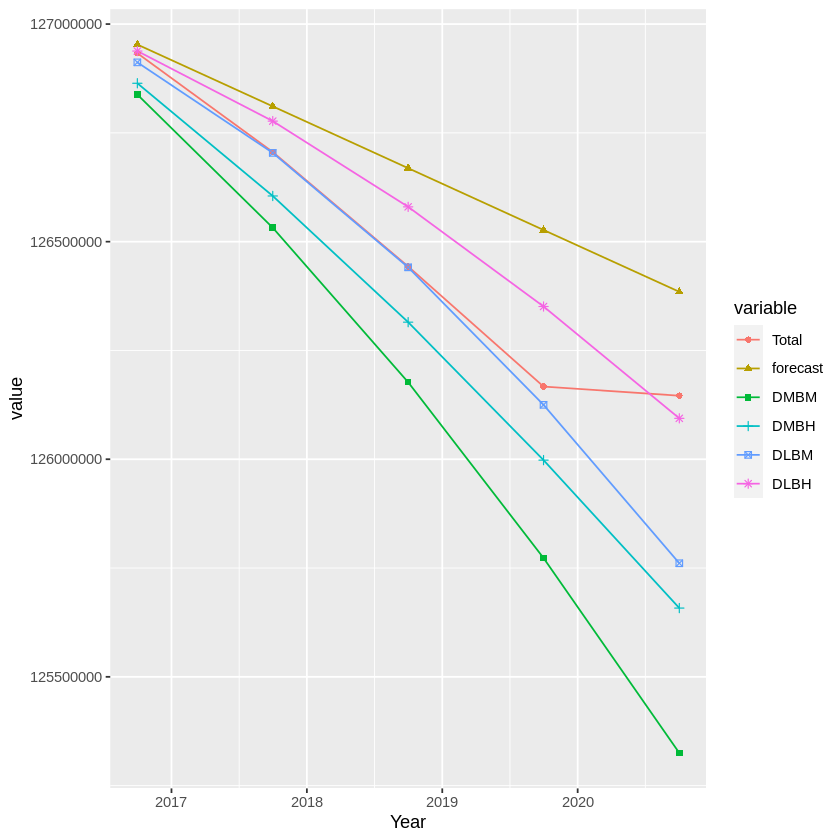

In [8]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
ipssURL = 
  c( "main/data/forecast_ipss.csv" )

repo |>
  paste0( ipssURL ) |>                    # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  mutate( Year = {
    paste0( Year, "-10-01" ) |>           # １０月１日現在の日付型にする
      as.Date()}
  ) ->
ipss_test

pop_test |>
  inner_join( ipss_test, by = "Year" ) |>
  cbind( forecast_trend$fit ) |>
  rename( forecast = "forecast_trend$fit" ) |>
  select( Year,
          Total,
          forecast,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) ->
join_test
join_test

# ライブラリの読み込み
library( reshape2 )

# 描画
join_test |> 
  melt( id = "Year",
        measure = c( "Total",
                     "forecast",
                     "DMBM",
                     "DMBH",
                     "DLBM",
                     "DLBH" )) |>
  ggplot( aes( x = Year,
               y = value,
               shape = variable,
               colour = variable,
               group = variable )) +
  geom_line() +
  geom_point()

どうやら、実データより２０万人弱、高く予測してしまったようです。  
人口変動の要因は一つではないので、もう少し細かいモデルが必要のようです。

# 次のステップ


*   同じ事をPythonでやってみる。　->　こちら
*   人口方程式の考え方に沿ってみる　->　こちら
